# Import the dataset

In [ ]:
!wget nipg1.inf.elte.hu:8765/fer2013.csv

--2021-10-21 19:24:47--  http://nipg1.inf.elte.hu:8765/fer2013.csv
Resolving nipg1.inf.elte.hu (nipg1.inf.elte.hu)... 157.181.160.161
Connecting to nipg1.inf.elte.hu (nipg1.inf.elte.hu)|157.181.160.161|:8765... failed: Connection refused.


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

# Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers, layers, models, Sequential
import os
import cv2
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
import math
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
import tensorflow as tf 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from sklearn.utils import class_weight


# Preprocessing

In [ ]:
df = pd.read_csv('fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Get X and Y

### Separating the train-valid-test subsets



In [ ]:
training = df.loc[df["Usage"] == "Training"]
public_test = df.loc[df["Usage"] == "PublicTest"]
private_test = df.loc[df["Usage"] == "PrivateTest"]

### Getting one hot encoded target values

In [ ]:
y_train = training["emotion"]

y_private = private_test["emotion"]

y_public = public_test["emotion"]


In [ ]:
class_weights = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

In [ ]:
class_weights

array([1.02660468, 9.40661861, 1.00104606, 0.56843877, 0.84912748,
       1.29337298, 0.82603942])

In [ ]:
y_train= to_categorical(y_train)
#y_private = to_categorical(y_private)
y_public = to_categorical(y_public)

### Reshaping and Normalizing the images

In [ ]:
x_train = training["pixels"].str.split(" ").tolist()
x_train = np.uint8(x_train)
x_train = x_train.reshape((training.shape[0], 48, 48, 1))
x_train = np.concatenate((x_train,)*3, axis=-1)
#x_train = x_train * (1/3.0)
#x_train = x_train.astype("float32") 


x_private = private_test["pixels"].str.split(" ").tolist()
x_private = np.uint8(x_private)
x_private = x_private.reshape((private_test.shape[0], 48, 48, 1))
x_private = np.concatenate((x_private,)*3, axis=-1)
#x_private = x_private * (1/255.0)
#x_private = x_private.astype("float32")


x_public = public_test["pixels"].str.split(" ").tolist()
x_public = np.uint8(x_public)
x_public = x_public.reshape((public_test.shape[0], 48, 48, 1))
x_public = np.concatenate((x_public,)*3, axis=-1)
#x_public = x_public * (1/255.0)
#x_public = x_public.astype("float32")

## Ploting some of the images 

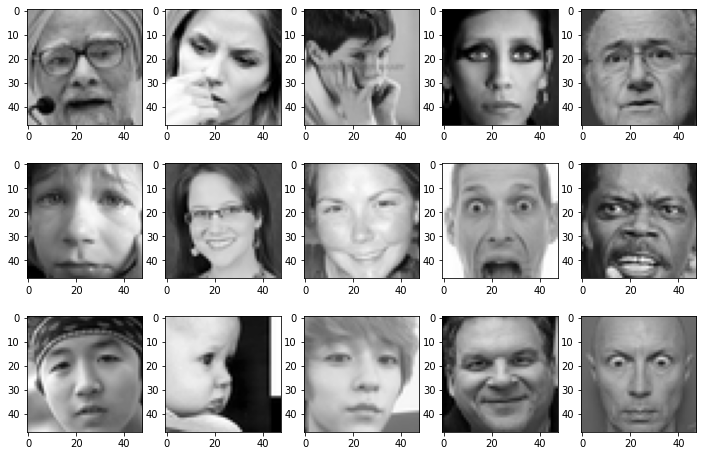

In [ ]:
plt.figure(0, figsize=(12,8))
for i in range(1, 16):
    plt.subplot(3,5,i)
    plt.imshow(x_train[i])
plt.show()

## ploting label histogram


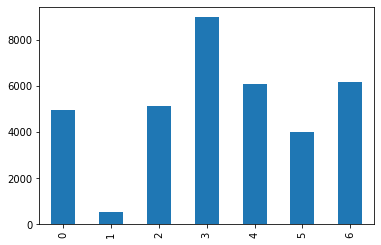

In [ ]:
df['emotion'].value_counts(sort=False).plot.bar()

## Demo: Data augmentation


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


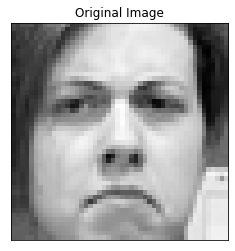

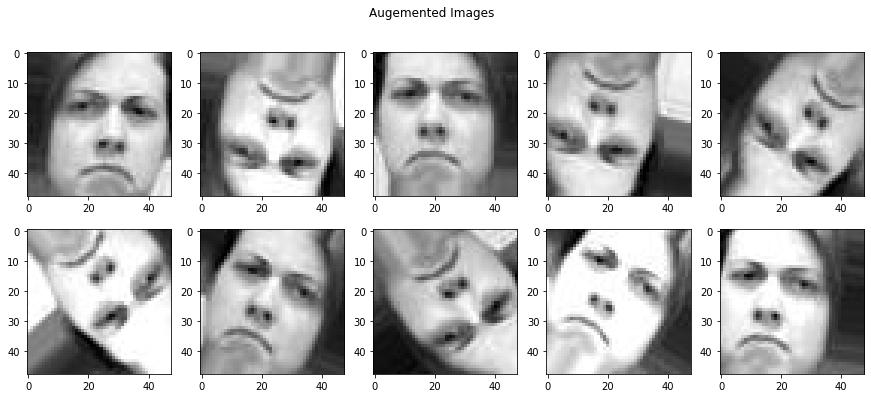

In [ ]:
demo_datagen = ImageDataGenerator(featurewise_center=True,
                            rotation_range=45,
                            width_shift_range=0.15,
                            height_shift_range=0.15,
                            shear_range=0.05,
                            brightness_range=[0.1, 1.5],
                            horizontal_flip=True,
                            vertical_flip=True)

!mkdir preview

x = x_train[40]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 10:
        break

plt.imshow(x_train[40, :, :, 0], cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2,5,i)
    plt.imshow(img)
    
    i += 1
    if i > 10:
        break
plt.suptitle('Augemented Images')
plt.show()

## Data generators


In [ ]:
# create generator to center images
datagen = ImageDataGenerator(featurewise_center=True, #Set input mean to 0 over the dataset, feature-wise.,
                            featurewise_std_normalization=True, # Divide inputs by std of the dataset, feature-wise.
                            rotation_range=45,
                            width_shift_range=0.15,
                            height_shift_range=0.15,
                            shear_range=0.05,
                            horizontal_flip=True,
                            )

datagen.fit(x_train)

train_iterator = datagen.flow(x_train, y_train, batch_size=64)
validation_iterator = datagen.flow(x_public, y_public, batch_size=64)
test_iterator = datagen.flow(x_private, y_private, batch_size=64)

### Model

In [ ]:
base_model = VGG16(input_shape = (48,48, 3), # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = 'imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
initial_learning_rate = 1e-2
def lr_time_based_decay(epoch, lr):
    return lr * math.exp(-0.1)

In [ ]:

model_1 = Sequential()
model_1.add(base_model)
model_1.add(layers.Flatten())
model_1.add(layers.Dense(2048, activation='relu'))
model_1.add(layers.Dropout(0.3))
model_1.add(layers.Dense(1024, activation='relu'))
model_1.add(layers.Dropout(0.3))
model_1.add(layers.Dense(512, activation='relu'))
model_1.add(layers.Dropout(0.3))
model_1.add(layers.Dense(256, activation='relu'))
model_1.add(layers.Dropout(0.3))
model_1.add(layers.Dense(128, activation='relu'))
model_1.add(layers.Dropout(0.3))
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dropout(0.3))
model_1.add(layers.Dense(7, activation='softmax'))

model_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    #optimizer = tf.keras.optimizers.Adam(),
    metrics=['acc']
)

In [ ]:
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
epochs = 100

history_1 = model_1.fit_generator(
    train_iterator,
    validation_data=validation_iterator,
    steps_per_epoch=len(train_iterator), 
    epochs=epochs,
    callbacks=[
              LearningRateScheduler(lr_time_based_decay, verbose=1),
              early_stopping
               ])


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0009048374610134307.
449/449 [==============================] - 47s 103ms/step - loss: 1.7637 - acc: 0.2781 - val_loss: 1.6712 - val_acc: 0.3502
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008187307807475673.
449/449 [==============================] - 46s 103ms/step - loss: 1.6808 - acc: 0.3422 - val_loss: 1.6285 - val_acc: 0.3697
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0007408182609837606.
449/449 [==============================] - 46s 102ms/step - loss: 1.6572 - acc: 0.3523 - val_loss: 1.6148 - val_acc: 0.3775
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0006703200923609524.
449/449 [==============================] - 46s 102ms/step - loss: 1.6374 - acc: 0.3639 - val_loss: 1.5977 - val_acc: 0.3820
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.000606530675391766.
449/449 [================

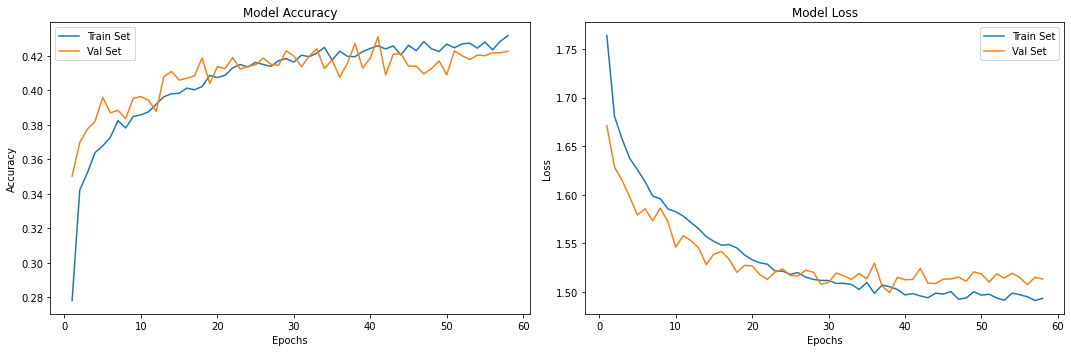

In [ ]:

acc = history_1.history['acc']
val_acc = history_1.history['val_acc']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs_range = range(1, len(history_1.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
model_1.save('model_1.h5') 

# Balenced model

In [ ]:
model_2 = Sequential()
model_2.add(base_model)
model_2.add(layers.Flatten())
model_2.add(layers.Dense(2048, activation='relu'))
model_2.add(layers.Dropout(0.3))
model_2.add(layers.Dense(1024, activation='relu'))
model_2.add(layers.Dropout(0.3))
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dropout(0.3))
model_2.add(layers.Dense(256, activation='relu'))
model_2.add(layers.Dropout(0.3))
model_2.add(layers.Dense(128, activation='relu'))
model_2.add(layers.Dropout(0.3))
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dropout(0.3))
model_2.add(layers.Dense(7, activation='softmax'))

model_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    #optimizer = tf.keras.optimizers.Adam(),
    metrics=['acc'])

In [ ]:
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8491274770777877,
 5: 1.293372978330405,
 6: 0.8260394187886635}

In [ ]:
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
epochs = 100

history_2 = model_2.fit_generator(
    train_iterator,
    validation_data=validation_iterator,
    steps_per_epoch=len(train_iterator), 
    epochs=epochs,
    class_weight = class_weights,
    callbacks=[
              LearningRateScheduler(lr_time_based_decay, verbose=1),
              early_stopping
               ])


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0009048374610134307.
449/449 [==============================] - 78s 105ms/step - loss: 1.9126 - acc: 0.1750 - val_loss: 1.8448 - val_acc: 0.2435
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008187307807475673.
449/449 [==============================] - 46s 103ms/step - loss: 1.8562 - acc: 0.2033 - val_loss: 1.7992 - val_acc: 0.2452
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0007408182609837606.
449/449 [==============================] - 46s 103ms/step - loss: 1.8314 - acc: 0.2125 - val_loss: 1.7957 - val_acc: 0.2315
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0006703200923609524.
449/449 [==============================] - 46s 103ms/step - loss: 1.8190 - acc: 0.2124 - val_loss: 1.7718 - val_acc: 0.2608
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.000606530675391766.
449/449 [================

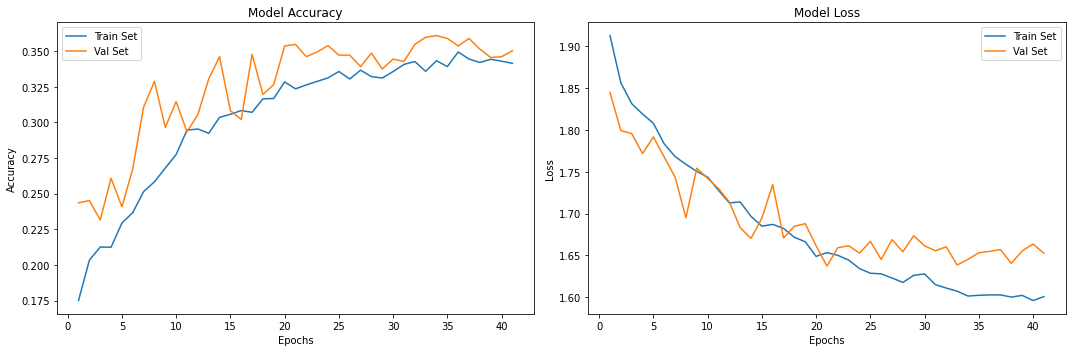

In [ ]:

acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs_range = range(1, len(history_2.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
model_2.save('model_2.h5') 

# Test


In [ ]:
classes = [0,1,2,3,4,5,6]

In [ ]:
model_1 = tf.keras.models.load_model('model_1.h5')
model_2 = tf.keras.models.load_model('model_2.h5')


In [ ]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Original data set

In [ ]:
pred_1 = model_1.predict_generator(test_iterator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
pred_1 = [np.argmax(p) for p in pred_1]

In [ ]:
pred_1 =np.array(pred_1)

In [ ]:
accuracy_1= accuracy_score(y_private, pred_1)
accuracy_1

0.18751741432153804

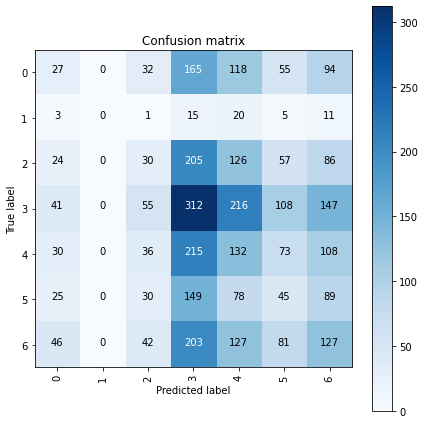

In [ ]:
confusion_mtx = confusion_matrix(y_private, pred_1) 
cm = plot_confusion_matrix(confusion_mtx, classes, normalize=False)

# Balenced dataset

In [ ]:
pred_2 = model_2.predict_generator(test_iterator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
pred_2 = [np.argmax(p) for p in pred_2]

In [ ]:
pred_2 =np.array(pred_2)

In [ ]:
accuracy_2 = accuracy_score(y_private, pred_2)
accuracy_2

0.14739481749791028

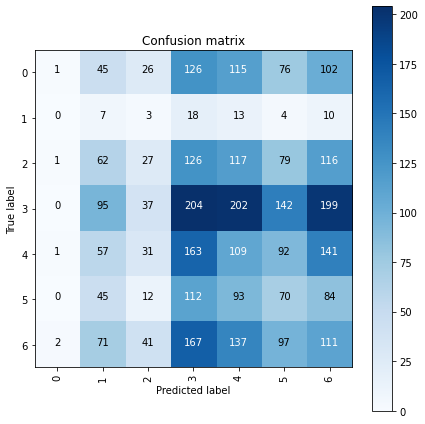

In [ ]:
confusion_mtx = confusion_matrix(y_private, pred_2) 
cm = plot_confusion_matrix(confusion_mtx, classes, normalize=False)